# MSDS 7331 - Mini Lab: Logistic Regression and SVMs

### Investigators
- [Matt Baldree](mailto:mbaldree@smu.edu?subject=mini-lab)
- [Tom Elkins](telkins@smu.edu?subject=mini-lab)
- [Austin Kelly](ajkelly@smu.edu?subject=mini-lab)
- [Murali Parthasarathy](mparthasarathy@smu.edu?subject=mini-lab)


<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:5px;'>
    <h3>Lab Instructions</h3>
    <p>You are to perform predictive analysis (classification) upon a data set: model the dataset using methods we have discussed in class: logistic regression and support vector machines, and making conclusions from the analysis. Follow the CRISP-DM framework in your analysis (you are not performing all of the CRISP-DM outline, only the portions relevant to the grading rubric outlined below). This report is worth 10% of the final grade. You may complete this assignment in teams of as many as three people.
Write a report covering all the steps of the project. The format of the document can be PDF, *.ipynb, or HTML. You can write the report in whatever format you like, but it is easiest to turn in the rendered iPython notebook. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.</p>
</div>

## 1 - Background
We continue our data science work on the 2015 Washington, D.C. Metro Crime data as refined in Lab 1. This dataset contains crime data specified as "OFFENSE". An offense code was established for each offense and the offense were grouped into a binary classification of property or violent crime. The number used for the code does not imply a level of severity they were simply applied in order of appearance). The table below provides a mapping of the textual offense to its code and type of crime.

|Offense|Offense_Code|Crime_Type|
|:------|:----------:|---------:|
|Theft/Other|1|2 (Property)|
|Theft from Auto|2|2 (Property)|
|Burglary|3|2 (Property)|
|Assault with Dangerous Weapon|4|1 (Violent)|
|Robbery|5|1 (Violent)|
|Motor Vehicle Theft|6|2 (Property)|
|Homicide|7|1 (Violent)|
|Sex Abuse|8|1 (Violent)|
|Arson|9|2 (Property)|

The dataset also contains a variety of geographic identifiers representing different political, social, and legal boundaries.

- DISTRICT -- the Police district within which the crime was committed
- Police Service Area (PSA) -- A subordinate area within a District
- Ward -- A political area, similar to a "county" in a larger state
- Advisory Neighborhood Committed (ANC) -- A social group consisting of neighbors and social leaders in a small geographic area
- Voting Precinct -- A political area for the management of voting residents
- Local Coordinates (XBLOCK and YBLOCK) -- location within the DC metro area based on the Maryland mapping system
- Global Coordinates (Latitude and Longitude) -- location on the planet

The dataset also contains time-based identifiers.
- The Start and End dates/times of when the crime *might* have been committed.
- The date/time the crime was reported (i.e. when the police responded and took the report)
- Shift - the police duty shift that responded to the crime (broken into 8-hour periods within a day)

# 2 - Predictive Analysis Goal
This mini-lab will predict a classification for the OFFENSE code and CRIME_TYPE given a set of features. Two classification models will be used to perform this classification - 1) logistic regression and 2) support vector machine (SVM). Parameters for these algorithms will be adjusted to determine the setting that yields the most accurate results. 

### Crime_Type (Violent/Property)
The first classification task is a binary classification, in which we attempt to build a model to predict whether the crime will be against a person (violent) or against property given the other features of the data (geographic location, time of day, political area, etc.). The goal is to help the Police manage resources more appropriately.

### Offense/Offense_Code
For the second classification task, we chose to attempt building a model to predict the type of offense (theft, homicide, assault, arson, etc.).  The hope is that if a type of crime could be predicted, then the Police would be better able to allocate offense-specific resources appropriately.

### Model Comparison
Secondarily, we seek to compare the accuracy of the models - i.e. if the Crime_Type prediction indicates a "Violent" crime, does the Offense prediction agree (Homicide, Sex Abuse, Robbery, or Assault).

# 3 - Data Preparation
Our dataset must be prepared for `scikit-learn` library of classifiers.

#### 3.1 Load Data

In [167]:
import pandas as pd
import numpy as np
from __future__ import print_function

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

# Read in the crime data from the Lab 1 CSV file
dc = pd.read_csv('data/DC_Crime_2015_Lab1.csv')

In [168]:
# remind ourselves about the columns we have in this dataset
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 26 columns):
REPORT_DAT              36489 non-null object
SHIFT                   36489 non-null object
OFFENSE                 36489 non-null object
METHOD                  36489 non-null object
DISTRICT                36442 non-null float64
PSA                     36441 non-null float64
WARD                    36489 non-null int64
ANC                     36489 non-null int64
NEIGHBORHOOD_CLUSTER    36489 non-null int64
CENSUS_TRACT            36489 non-null int64
VOTING_PRECINCT         36489 non-null int64
CCN                     36489 non-null int64
XBLOCK                  36489 non-null float64
YBLOCK                  36489 non-null float64
START_DATE              36489 non-null object
END_DATE                36489 non-null object
PSA_ID                  36489 non-null int64
DistrictID              36489 non-null int64
SHIFT_Code              36489 non-null int64
OFFENSE_Code          

#### 3.2 Break crime start date into usable values for prediction

In [169]:
# convert START_DATE to datetime
dc.START_DATE = pd.to_datetime(dc.START_DATE)

# add the month of the crime
dc['Crime_Start_Month'] = dc["START_DATE"].map(lambda x: x.month)
dc.Crime_Start_Month = dc.Crime_Start_Month.astype('int64')

# add day of the month
dc['Crime_Start_Day'] = dc["START_DATE"].map(lambda x:x.day)
dc.Crime_Start_Day = dc.Crime_Start_Day.astype('int64')

# add hour of the day
dc['Crime_Start_Hour'] = dc["START_DATE"].map(lambda x:x.hour)
dc.Crime_Start_Hour = dc.Crime_Start_Hour.astype('int64')

In [170]:
# printout offenses and codes for reference
print(dc.OFFENSE.unique())
print(dc.OFFENSE_Code.unique())

# printout crime type for reference - 1:violent, 2:property
print(dc.CRIME_TYPE.unique())

['THEFT/OTHER' 'THEFT F/AUTO' 'BURGLARY' 'ASSAULT W/DW' 'ROBBERY'
 'MOTOR VEHICLE THEFT' 'HOMICIDE' 'SEX ABUSE' 'ARSON']
[1 2 3 4 5 6 7 8 9]
[2 1]


In [171]:
# set new dataframe to use for classification; might need existing columns for later analysis
df_classify = dc.copy()

# remove attributes that are redundant with other attributes
# most redundant because of Codes
# TIME_TO_REPORT is redundant with AGE
# XBLOCK and YBLOCK redundant with latitude and longitude
for attrib in ('OFFENSE', 'METHOD', 'DISTRICT', 'REPORT_DAT', 'CCN', 'START_DATE', 'END_DATE', 
               'SHIFT', 'PSA', 'TIME_TO_REPORT', 'XBLOCK', 'YBLOCK'):
    if attrib in df_classify:
        del df_classify[attrib]

In [172]:
df_classify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 17 columns):
WARD                    36489 non-null int64
ANC                     36489 non-null int64
NEIGHBORHOOD_CLUSTER    36489 non-null int64
CENSUS_TRACT            36489 non-null int64
VOTING_PRECINCT         36489 non-null int64
PSA_ID                  36489 non-null int64
DistrictID              36489 non-null int64
SHIFT_Code              36489 non-null int64
OFFENSE_Code            36489 non-null int64
METHOD_Code             36489 non-null int64
CRIME_TYPE              36489 non-null int64
AGE                     36489 non-null int64
Latitude                36489 non-null float64
Longitude               36489 non-null float64
Crime_Start_Month       36489 non-null int64
Crime_Start_Day         36489 non-null int64
Crime_Start_Hour        36489 non-null int64
dtypes: float64(2), int64(15)
memory usage: 4.7 MB


#### 3.2 Break offense code into a column for each possible outcome.

In [173]:
# perform one-hot encoding of non-binary categorical data
tmp_df = pd.get_dummies(df_classify.SHIFT_Code,prefix='ShiftCode')
df_classify = pd.concat((df_classify, tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(df_classify.METHOD_Code,prefix='MethodCode')
df_classify = pd.concat((df_classify, tmp_df),axis=1) # add back into the dataframe


df_classify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 23 columns):
WARD                    36489 non-null int64
ANC                     36489 non-null int64
NEIGHBORHOOD_CLUSTER    36489 non-null int64
CENSUS_TRACT            36489 non-null int64
VOTING_PRECINCT         36489 non-null int64
PSA_ID                  36489 non-null int64
DistrictID              36489 non-null int64
SHIFT_Code              36489 non-null int64
OFFENSE_Code            36489 non-null int64
METHOD_Code             36489 non-null int64
CRIME_TYPE              36489 non-null int64
AGE                     36489 non-null int64
Latitude                36489 non-null float64
Longitude               36489 non-null float64
Crime_Start_Month       36489 non-null int64
Crime_Start_Day         36489 non-null int64
Crime_Start_Hour        36489 non-null int64
ShiftCode_1             36489 non-null float64
ShiftCode_2             36489 non-null float64
ShiftCode_3             3648

# 4 - Dataset Review
#### 4.1 Now it is time to review our data before modeling it. We will begin by displaying simple statistics of our columns.

In [174]:
df_classify.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
WARD,36489.0,4.421305,2.339371e+00,1.000000,2.00000,5.000000,6.000000,8.000000e+00
ANC,36489.0,47.260243,2.369393e+01,11.000000,23.00000,53.000000,65.000000,8.500000e+01
NEIGHBORHOOD_CLUSTER,36489.0,17.584286,1.186310e+01,0.000000,6.00000,18.000000,26.000000,3.900000e+01
CENSUS_TRACT,36489.0,6192.348324,3.160175e+03,0.000000,3400.00000,7000.000000,8904.000000,1.110000e+04
VOTING_PRECINCT,36489.0,70.072460,4.197338e+01,0.000000,33.00000,72.000000,106.000000,1.430000e+02
PSA_ID,36489.0,374.208885,1.945646e+02,101.000000,206.00000,401.000000,506.000000,7.080000e+02
DistrictID,36489.0,3.696265,1.947842e+00,1.000000,2.00000,4.000000,5.000000,7.000000e+00
SHIFT_Code,36489.0,1.817836,7.272862e-01,1.000000,1.00000,2.000000,2.000000,3.000000e+00
OFFENSE_Code,36489.0,2.468634,1.717339e+00,1.000000,1.00000,2.000000,3.000000,9.000000e+00
METHOD_Code,36489.0,1.123571,4.149231e-01,1.000000,1.00000,1.000000,1.000000,3.000000e+00


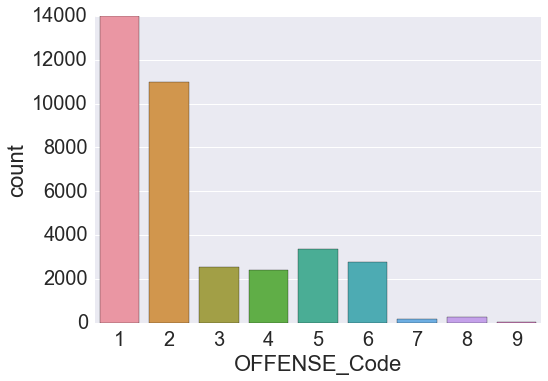

In [175]:
# 1: Theft/Other, 2: Theft from Auto, 3: Burglary, 4: Assault with Dangerous Weapon,
# 5: Robbery, 6: Motor Vehicle Theft, 7: Homicide, 8: Sex Abuse, 9: Arson

tmpdf = df_classify[['OFFENSE_Code']]
sns.countplot(x='OFFENSE_Code', data=tmpdf)

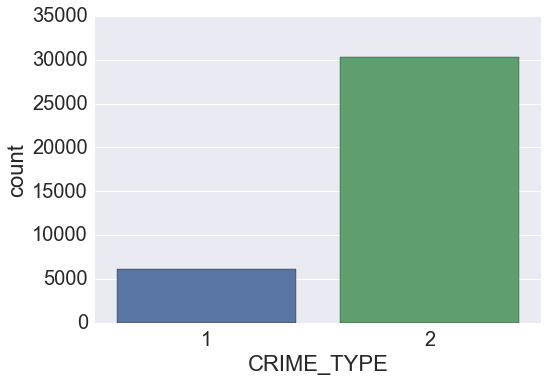

In [176]:
# 1: violent, 2: propery

tmpdf = df_classify[['CRIME_TYPE']]
sns.countplot(x='CRIME_TYPE', data=tmpdf)

# 5 - Training and Testing Split

For training and testing purposes, let's gather the data we have and grab 80% of the instances for training and the remaining 20% for testing. Moreover, let's repeat this process of separating the testing and training data three times. We will use the hold out cross validation method built into `scikit-learn`.

In [177]:
from sklearn.cross_validation import ShuffleSplit

# CRIME_TYPE target and attributes
crime_type_target = 'CRIME_TYPE'
crime_type_features = ['WARD', 'ANC', 'NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT', 'VOTING_PRECINCT', 'PSA_ID', 
                       'DistrictID', 'ShiftCode_1', 'ShiftCode_2', 'ShiftCode_3', 'MethodCode_1',
                       'MethodCode_1', 'MethodCode_2', 'MethodCode_3', 'AGE', 'Latitude', 'Longitude', 
                       'Crime_Start_Month', 'Crime_Start_Day', 'Crime_Start_Hour']

y_crime_type = df_classify[crime_type_target].values
X_crime_type = df_classify[crime_type_features].values

# OFFENSE_Code target and attributes
offense_code_target = 'OFFENSE_Code'
offense_code_features = ['WARD', 'ANC', 'NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT', 'VOTING_PRECINCT', 'PSA_ID', 
                       'DistrictID', 'ShiftCode_1', 'ShiftCode_2', 'ShiftCode_3', 'MethodCode_1',
                       'MethodCode_1', 'MethodCode_2', 'MethodCode_3', 'AGE', 'Latitude', 'Longitude', 
                       'Crime_Start_Month', 'Crime_Start_Day', 'Crime_Start_Hour']

y_offense_code = df_classify[offense_code_target].values
X_offense_code = df_classify[offense_code_features].values
    
    
# to use the cross validation object in scikit-learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y_crime_type)
cv_object = ShuffleSplit(n=num_instances, n_iter=num_cv_iterations, test_size=0.2)
                         
print(cv_object)

ShuffleSplit(36489, n_iter=3, test_size=0.2, random_state=None)


# Below is the work Ben did. I'm using it for reference, but my main inspiration is the 04. Logits and SVM notebook from class.

<a id='data_prep'></a>
## 1 - Data Preparation

In [78]:
#1.0.1 - Import the libraries we will need
import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=2)
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# Graph Lab Support
import graphlab as gl
import graphlab
# keep data visualizations within notebook
graphlab.canvas.set_target('ipynb')

# Read in the crime data from the Lab 1 CSV file
dc = pd.read_csv('data/DC_Crime_2015_Lab1.csv')

### *** TO DO:
###  * Incorporate a feature for the weather conditions during START_DATE and END_DATE so we can use rainfall/max temp/min temp in the regression
dc['REPORT_DAT'] = pd.to_datetime(dc['REPORT_DAT'])
dc=dc.rename(columns = {'REPORT_DAT':'REPORT_DATE'})
dc['START_DATE'] = pd.to_datetime(dc['START_DATE'])
dc['END_DATE'] = pd.to_datetime(dc['END_DATE'])
dc['XBLOCK'] = dc['XBLOCK'].astype(np.float64)
dc['YBLOCK'] = dc['YBLOCK'].astype(np.float64)
dc['Crime_Month'] = dc["START_DATE"].map(lambda x: x.month)
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 27 columns):
REPORT_DATE             36489 non-null datetime64[ns]
SHIFT                   36489 non-null object
OFFENSE                 36489 non-null object
METHOD                  36489 non-null object
DISTRICT                36442 non-null float64
PSA                     36441 non-null float64
WARD                    36489 non-null int64
ANC                     36489 non-null int64
NEIGHBORHOOD_CLUSTER    36489 non-null int64
CENSUS_TRACT            36489 non-null int64
VOTING_PRECINCT         36489 non-null int64
CCN                     36489 non-null int64
XBLOCK                  36489 non-null float64
YBLOCK                  36489 non-null float64
START_DATE              36489 non-null datetime64[ns]
END_DATE                36489 non-null datetime64[ns]
PSA_ID                  36489 non-null int64
DistrictID              36489 non-null int64
SHIFT_Code              36489 non-null int6

In [ ]:
# histogram of Crimes Month
dc['Crime_Month'].hist()
plt.title('Histogram of Crimes_Month')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
# histogram of Offense Code
dc['OFFENSE_Code'].hist()
plt.title('Histogram of Offense Code')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
# histogram of PSA ID"
dc['PSA_ID'].hist()
plt.title('Histogram of PSA_ID')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
# histogram of CRIME_TYPE"
dc['CRIME_TYPE'].hist()
plt.title('Histogram of CRIME_TYPE')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
#METHOD_Code
dc['METHOD_Code'].hist()
plt.title('Histogram of METHOD_Code')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
#DistrictID
dc['DistrictID'].hist()
plt.title('Histogram of DistrictID')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
#Ward
dc['WARD'].hist()
plt.title('Histogram of WARD')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

In [ ]:
#VOTING_PRECINCT
dc['VOTING_PRECINCT'].hist()
plt.title('Histogram of VOTING_PRECINCT')
plt.xlabel('Month Category')
plt.ylabel('Frequency')

### 1.1 - Dataset Review
We continue to use our dataset selected for lab 1 - the 2015 Washington, D.C. Metro Crime data.  That dataset contained the type of crime committed (Field name "OFFENSE"; from which we derived an "Offense_Code" field and ascribed a numeric value for each offense type (NOTE: The number used does not imply a level of severity they were simply applied in order of appearance).  :

|Offense|Offense_Code|Crime_Type|
|:------|:----------:|---------:|
|Theft/Other|1|2 (Property)|
|Theft from Auto|2|2 (Property)|
|Burglary|3|2 (Property)|
|Assault with Dangerous Weapon|4|1 (Violent)|
|Robbery|5|1 (Violent)|
|Motor Vehicle Theft|6|2 (Property)|
|Homicide|7|1 (Violent)|
|Sex Abuse|8|1 (Violent)|
|Arson|9|2 (Property)|

The dataset contains a variety of geographic identifiers representing different political, social, and legal boundaries.

DISTRICT -- the Police district within which the crime was committed<br>
Police Service Area (PSA) -- A subordinate area within a District<br>
Ward -- A political area, similar to a "county" in a larger state<br>
Advisory Neighborhood Committed (ANC) -- A social group consisting of neighbors and social leaders in a small geographic area<br>
Voting Precinct -- A political area for the management of voting residents<br>
Local Coordinates (XBLOCK and YBLOCK) -- location within the DC metro area based on the Maryland mapping system<br>
Global Coordinates (Latitude and Longitude) -- location on the planet<br>

There are also time-based identifiers provided in the data
* The Start and End dates/times of when the crime *might* have been committed.
* The date/time the crime was reported (i.e. when the police responded and took the report)
* These can be further decomposed to Seasons, Months, Weeks, Day of the Week, etc.
* Shift - the police duty shift that responded to the crime (broken into 8-hour periods within a day)

From these time-based data we could associate environmental conditions as well, including temperatures, rainfall, phase of the moon, etc.

These features give us a variety of ways to attempt to classify the data.

### 1.2 - Classification Tasks
We decided to take a look at two different classification processes with our data set.

#### 1.2.1 - Crime_Type (Violent/Property)
The second classification task is a binary classification, in which we attempt to build a model to predict whether the crime will be against a person (violent) or against property. Again, the goal is to help the Police manage resources more appropriately.

#### 1.2.2 - Offense/Offense_Code
For the first classification task, we chose to attempt building a model to predict the type of offense given the other features of the data (geographic location, time of day, political area, etc.).  The hope is that if a type of crime could be predicted, then the Police would be better able to allocate offense-specific resources appropriately.

#### 1.2.3 - Model Comparison
Secondarily, we seek to compare the accuracy of the models - i.e. if the Crime_Type prediction indicates a "Violent" crime, does the Offense prediction agree (Homicide, Sex Abuse, Robbery, or Assault).


<a id="model_building"></a>
## 2 - Model Building

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>SVM and Logistic Regression Modeling</h3>
    <ol><li>[<b>50 points</b>] Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.</li>
    <li>[<b>10 points</b>]  Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.</li>
    <li>[<b>30 points</b>] Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?</li>
    <li>[<b>10 points</b>]  Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain.</li>
</ol>
</div>

### 2.1 - Logistic Regression Model for Crime_Type (Rubric Item 1)

In [ ]:
#2.1.1 Dataset creation

#  The field "CRIME_TYPE" exists as 1 = Violent, and 2 = Property.  
#  We subtract from 2 to make it 1 = Violent, and 0 = Property
LRM_Response = 2 - dc["CRIME_TYPE"]
#print LRM_Response

#  What is the mean response
Mean_Response = LRM_Response.mean()
print "Mean response for the entire data set is " + str(Mean_Response)

Guess_Rate = 1.0 - Mean_Response
print "If we simply guessed 'Property' crime all the time, our accuracy would be " + str(Guess_Rate)

#  Set up model using all relevant features
LRM_Features = dc[["PSA_ID","WARD","ANC","NEIGHBORHOOD_CLUSTER","CENSUS_TRACT","VOTING_PRECINCT","SHIFT_Code","Latitude","Longitude","Crime_Month"]]
#print LRM_Features

#  Fit our model
LRM_Model = LogisticRegression()
LRM_Model = LRM_Model.fit(LRM_Features, LRM_Response)

#  How accurate is it?
Model_Acc = LRM_Model.score(LRM_Features, LRM_Response)
print "Accuracy of Logistic Regression model is " + str(Model_Acc)

if Model_Acc > Guess_Rate:
    print "The Logistic Regression model is better than simply guessing"
else:
    print "The Logistic Regression model is worse than simply guessing"


In [ ]:
#  Display the coefficients to see if they tell us anything
pd.DataFrame(zip(LRM_Features.columns, np.transpose(LRM_Model.coef_)))

* The most significant factor is the SHIFT (i.e. the time of day)
* The second-most significant factor is Longitude, implying that as you move east, your chances of being involved in a violent crime increases
* The third-most significant factor is political WARD, so there are some Wards that are worse than others
* The fourth-most significant factor is Latitude, but negatively, so there is a greater chance of being involved in a violent crime as you move south

In [ ]:
# Split the data into a training set and a test set (80/20)

LRM_XTrain, LRM_XTest, LRM_YTrain, LRM_YTest = train_test_split(LRM_Features, 
                                                                LRM_Response, 
                                                                test_size=0.2, 
                                                                random_state=0)

# Fit the same features against the training data
LRM_Model2 = LogisticRegression()
LRM_Model2.fit(LRM_XTrain, LRM_YTrain)

#  How accurate is it?
Model_Acc = LRM_Model2.score(LRM_Features, LRM_Response)
print "Accuracy of Logistic Regression model is " + str(Model_Acc)

if Model_Acc > Guess_Rate:
    print "The Logistic Regression model is better than simply guessing"
else:
    print "The Logistic Regression model is worse than simply guessing"


In [ ]:
predicted = LRM_Model2.predict(LRM_XTest)
print predicted

# generate class probabilities
probs = LRM_Model2.predict_proba(LRM_XTest)
print probs

# generate evaluation metrics
print metrics.accuracy_score(LRM_YTest, predicted)
print metrics.roc_auc_score(LRM_YTest, probs[:, 1])

print metrics.confusion_matrix(LRM_YTest, predicted)
print metrics.classification_report(LRM_YTest, predicted)

In [ ]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), 
                         LRM_Features,
                         LRM_Response, 
                         scoring='accuracy', cv=10)
print scores
print scores.mean()

### 2.2 - Support Vector Machine Model for Crime_Type (Rubric Item 1)

### 2.3 - Logistic Regression Model for Offense_Code (Exceptional Work)

# Case 1a: Logistic Regression 

# Multi-variate Classification Analysis without Dummy Variables for the Input Categorical Variables

* **Python 2.7 skLearn Libraries**
* **Similar to the analysis done with Logistic Regression Model for Crime_Type**


In [ ]:
#2.1.1 Dataset creation

#  The field "OFFENSE_Code" exists as 1 = XX, 2 = YY, ...... 9 = ZZ 
#  OFFENSE_Code is a Multi-Variate Classification 
#  LogisticRegression can handle multiple classes out-of-the-box.
#  http://stackoverflow.com/questions/36760000/python-how-to-use-multinomial-logistic-regression-using-sklearn
LRM_Response = dc["OFFENSE_Code"]
#print LRM_Response

my_custom_features = ["PSA_ID",
                      "WARD",
                      "ANC",
                      "NEIGHBORHOOD_CLUSTER",
                      "CENSUS_TRACT",
                      "VOTING_PRECINCT",
                      "SHIFT_Code",
                      "Crime_Month",
                      "DistrictID",
                      "Latitude",
                      "Longitude"]

#  Set up model using all relevant features
LRM_Features = dc[my_custom_features]
#print LRM_Features

In [ ]:
# flatten y into a 1-D array
#LRM_Response = np.ravel(LRM_Response)

# Logistic Regression

Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!

In [ ]:
# instantiate a logistic regression model, and fit with LRM_Features and LRM_Response
#  Fit our model
LRM_Model3 = LogisticRegression()
LRM_Model3 = LRM_Model3.fit(LRM_Features, LRM_Response)

# check the accuracy on the training set
LRM_Model3.score(LRM_Features, LRM_Response)

In [ ]:
# what percentage had OFFENSE_Code?
LRM_Response.mean()

Let's examine the coefficients to see what we learn.

In [ ]:
# examine the coefficients
pd.DataFrame(zip(LRM_Features.columns, np.transpose(LRM_Model.coef_)))

# Each of the values listed in the table seems to be a vector of values

* The most significant factor is the CENSUS_TRACT (positive) 
* The second-most significant factor is SHIFT_Code (negative)
* The third-most significant factor is WARD (negative)
* The fourth-most significant factor is NEIGHBORHOOD_CLUSTER (negative)

In [ ]:
# Split the data into a training set and a test set (80/20)

LRM_XTrain, LRM_XTest, LRM_YTrain, LRM_YTest = train_test_split(LRM_Features, 
                                                                LRM_Response, 
                                                                test_size=0.2, 
                                                                random_state=0)

# Fit the same features against the training data
LRM_Model4 = LogisticRegression()
LRM_Model4.fit(LRM_XTrain, LRM_YTrain)

#  How accurate is it?
Model_Acc = LRM_Model4.score(LRM_Features, LRM_Response)
print "Accuracy of Logistic Regression model is:\t{:04.2f}% ".format(Model_Acc*100)

# Case 1b: Logistic Regression¶
Multi-variate Classification Analysis without Dummy Variables for the Input Categorical Variables

* **Python 2.7 skLearn Libraries**
* **Similar to the analysis done with Logistic Regression Model Dr. Eric Larson**

In [ ]:
list(dc)

In [ ]:
misc_input_features = ['REPORT_DATE',
                 'SHIFT',
                 'METHOD',
                 'DISTRICT',
                 'PSA',
                 'CCN',
                 'XBLOCK',
                 'YBLOCK',
                 'START_DATE',
                 'END_DATE',
                 'AGE',
                 'TIME_TO_REPORT']

for feature in misc_input_features:
    if feature in dc:
        del dc[feature]
   
output_features = ['OFFENSE',
                  'METHOD_Code',
                  'CRIME_TYPE']

for feature in output_features:
    if feature in dc:
        del dc[feature]

In [ ]:
list(dc)

# Training and Testing Split
For training and testing purposes, let's gather the data we have and grab 80% of the instances for training and the remaining 20% for testing. Moreover, let's repeat this process of separating the testing and training data three times. We will use the hold out cross validation method built into `scikit-learn`.

In [ ]:
from sklearn.cross_validation import ShuffleSplit

# we want to predict the X and y data as follows:
if 'OFFENSE_Code' in dc:
    y = dc['OFFENSE_Code'].values # get the labels we want
    del dc['OFFENSE_Code'] # get rid of the class label
    X = dc.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

# Logistic Regression

Now let's use Logistic Regression from scikit-learn. The documentation can be found here:


http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Multiclass Option

* 'ovr' versus 'multinomial'
  * 'ovr': Binary Classifier
  * 'multinomial': Multiclass classification means a classification task with more than two classes
  
  
  * **OFFENSE_Code** is a multivariate classification variable which can be either one of nine values listed above (0 thru 9).
    * Therefore, we MUST use the 'multinomial' option. 
    * Out of the box, the multiclass option is defaulted to 'ovr' which is a binary classification!!
    
    
  * I found that the solver = sag did not work with my Python kernel
     * Caused Python compilation error
  * Switched to 'newton-cg' with max_iter=150 the LogisticRegressio() worked without any errors.
      * It took some time for the code to actually execute.
      * Be patient
  
* Multiclass classification means a classification task with more than two classes; e.g., classify a set of images of fruits which may be oranges, apples, or pears. Multiclass classification makes the assumption that each sample is assigned to one and only one label: a fruit can be either an apple or a pear but not both at the same time.

* http://stackoverflow.com/questions/36523558/multi-class-logistic-regression-in-scikit-learn

# More on Logistic Regression

* It became apparent to carefully read the sklearn on-line documentation to gain a full understanding on how to use the LogisticRegression API

|Case|Solver|
|:------|:----------:|
|Small dataset or L1 penalty|“liblinear”|
|Multinomial loss or large dataset|“lbfgs”, “sag” or “newton-cg”|
|"solver" option | The "sag" option caused Python kernel compilation errors |
| "solver" option | Tested with "lbfgs" and "newton-cg" ONLY |
|      | Code listed below will generate the multi-variate classificaton based on the "solver" options used |
|Very Large dataset| 	“sag”|



* The “lbfgs”, “sag” and “newton-cg” solvers only support L2 penalization and are found to converge faster for some high dimensional data. 

* Setting multi_class to “multinomial” with these solvers learns a true multinomial logistic regression model, which means that its probability estimates should be better calibrated than the default “one-vs-rest” setting. 

* The “lbfgs”, “sag” and “newton-cg”” solvers cannot optimize L1-penalized models, therefore the “multinomial” setting does not learn sparse models.

In [ ]:
'''
MultiNomialLogisticRegression:

Perform Multi-nomial/Multi-Variate Logistic Regression
No need to duplicate code through-out this IPython notebook
Out of the box, the LogisticRegression class defaults to 
Binary Classification.  Here we, need the output variable
to support multiple values; therefore we need to setup the
LogisiticRegression API for multi-nomial.

Also note that every time you run the code below, it randomly 
creates a new training and testing set, so accuracy will be 
different each time
'''

# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

def MultiNomialLogisticRegression():
    
    from sklearn.linear_model import LogisticRegression
    from sklearn import metrics as mt
    
    # first we create a reusable logisitic regression object
    #   here we can setup the object with different learning parameters and constants
    # multi_class : str, {‘ovr’, ‘multinomial’}, default: ‘ovr’
    '''
    Multiclass option can be either ‘ovr’ or ‘multinomial’. 

    If the option chosen is ‘ovr’, 
      then a binary problem is fit for each label.
    Else the loss minimised is the multinomial loss fit across the entire 
    probability distribution. 
    Works only for the ‘newton-cg’, ‘sag’ and ‘lbfgs’solver.
    solver in [‘newton-cg’, ‘sag’ and ‘lbfgs’]
    '''
    multi_class = 'multinomial'

    # now we can use the cv_object that we setup before to iterate through the 
    #    different training and testing sets. Each time we will reuse the logisitic regression 
    #    object, but it gets trained on different data each time we use it.

    for solver in ('lbfgs', 'newton-cg'):
        
        lr_clf = LogisticRegression(penalty='l2',  
                                    multi_class=multi_class,
                                    max_iter=200,
                                    solver=solver) # get object
    
        print("\n\n")
        iter_num=0
        # the indices are the rows used for training and testing in each iteration
        for train_indices, test_indices in cv_object: 
            # I will create new variables here so that it is more obvious what 
            # the code is doing (you can compact this syntax and avoid duplicating memory,
            # but it makes this code less readable)
            X_train = X[train_indices]
            y_train = y[train_indices]
    
            X_test = X[test_indices]
            y_test = y[test_indices]
    
            # train the reusable logisitc regression model on the training data
            lr_clf.fit(X_train,y_train)  # train object
            y_hat = lr_clf.predict(X_test) # get test set precitions

            # now let's get the accuracy and confusion matrix for this iterations of training/testing
            acc = mt.accuracy_score(y_test,y_hat)
            conf = mt.confusion_matrix(y_test,y_hat)
            print("SOLVER ALGORITHM USED:", solver)
            print("====Iteration",iter_num)
            print("accuracy", acc )
            print("\nconfusion matrix\n")
            print (conf)
            print("\n")
            iter_num+=1
            
    return lr_clf, X_train, y_train, X_test, y_test


In [ ]:
lr_clf, X_train, y_train, X_test, y_test = MultiNomialLogisticRegression()

In [ ]:
# this does the exact same thing as the above block of code, but with shorter syntax
from sklearn import metrics as mt

for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

In [ ]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.cross_validation import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

In [ ]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    multi_class = 'multinomial' 
    solver = 'lbfgs'
    lr_clf = LogisticRegression(penalty='l2',  
                                multi_class=multi_class,
                                max_iter=200,
                                solver=solver) # get object
    
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05))

# Interpretting weights

Okay, so now lets take the last trained model for logistic regression and try to interpret the weights for the model. Is there something about the weights that makes this model more interpretable?

In [ ]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = dc.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct? 

These weight interpretations are not neccessarily interpretable because of the values we had. Very large attribute values could just as easily be assigned a higher weight. Instead, let's normalize the feature values so that all the attributes are on the same dynamic range. Once we normalize the attributes, the weights should have magnitudes that reflect their poredictive power in the logistic regression model.

In [ ]:
from sklearn.preprocessing import StandardScaler

'''
# train the model just as before
multi_class = 'multinomial' 
solver = 'lbfgs'
lr_clf = LogisticRegression(penalty='l2',  
                            multi_class=multi_class,
                            max_iter=200,
                            solver=solver) # get object
'''

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
#lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)

multi_class = 'multinomial' 
solver = 'lbfgs'
lr_clf = LogisticRegression(penalty='l2',  
                            multi_class=multi_class,
                            max_iter=200,
                            solver=solver) # get object

lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,dc.columns) # combine attributes
#zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out


In [ ]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0],index=dc.columns)
weights.plot(kind='bar')
plt.show()

**For more improvement and guarding against overfitting:** At this point it would make sense to remove variables that are highly related to one another or ones that are irrelevant and keep going with the weights analysis. What variables would you remove?

In [ ]:
# you can also apply the StandardScaler function insied of the validation loop 
#  but this requires the use of PipeLines in scikit. Here is an example, but we will go over more 
#  thorough examples later in class

from sklearn.pipeline import Pipeline

std_scl = StandardScaler()
#lr_clf = LogisticRegression(penalty='l2', C=0.05) 
multi_class = 'multinomial' 
solver = 'lbfgs'
lr_clf = LogisticRegression(penalty='l2',  
                            multi_class=multi_class,
                            max_iter=200,
                            solver=solver) # get object

# create the pipline
piped_object = Pipeline([('scale', std_scl), ('logit_model', lr_clf)])


# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    piped_object.fit(X[train_indices],y[train_indices])  # train object

# it is a little odd getting trained objects from a  pipeline:
trained_model_from_pipeline = piped_object.named_steps['logit_model']

# now look at the weights
weights = pd.Series(trained_model_from_pipeline.coef_[0],index=dc.columns)
weights.plot(kind='bar')
plt.show()

# SVM Support

In [ ]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object: 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [ ]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

In [ ]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

In [ ]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=dc.columns)
weights.plot(kind='bar')

In [ ]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = dc.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['OFFENSE_Code'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
dc['OFFENSE_Code'] = y # also add it back in for the original data
df_support.info()

# Case 2: Logistic Regression 

# Multi-variate Classification Analysis with Dummy Variables for the Input Categorical Variables

* **Python 2.7 skLearn Libraries**

# Initial Attempt to Perform One Hot Encoding on the Input Categorical Variables

##### The Python 2.7.X kernel could not handle all of the One Hot Encoding for all of the categorical variable computation in one cell and threw an error.

* **Therefore, in each unique cell performed one hot encoding on each categorical variable individually.   This was inconvenient but we will note this issue and investigate this issue later.**

Transform all of the input categorical attributes within the final **DC DataFrame** --one for each possible variable outcome.  Here, we will use OneHotEncoding to take on each value for each variable attribute value.

Input Categorical Attributes/Features provided in the DC DataFrame
* **PSA_ID**
* **WARD**
* **ANC**
* **NEIGHBORHOOD_CLUSTER**
* **CENSUS_TRACT**
* **VOTING_PRECINCT**
* **DistrictID**
* **SHIFT_Code**
* **Crime_Month**

In [57]:
del dc

In [58]:
#1.0.1 - Import the libraries we will need
import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=2)
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

# Graph Lab Support
import graphlab as gl
import graphlab
# keep data visualizations within notebook
graphlab.canvas.set_target('ipynb')

dc = pd.read_csv('data/DC_Crime_2015_Lab1.csv')

### *** TO DO:
###  * Incorporate a feature for the weather conditions during START_DATE and END_DATE so we can use rainfall/max temp/min temp in the regression
dc['REPORT_DAT'] = pd.to_datetime(dc['REPORT_DAT'])
dc=dc.rename(columns = {'REPORT_DAT':'REPORT_DATE'})
dc['START_DATE'] = pd.to_datetime(dc['START_DATE'])
dc['END_DATE'] = pd.to_datetime(dc['END_DATE'])
dc['XBLOCK'] = dc['XBLOCK'].astype(np.float64)
dc['YBLOCK'] = dc['YBLOCK'].astype(np.float64)
dc['Crime_Month'] = dc["START_DATE"].map(lambda x: x.month)
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 27 columns):
REPORT_DATE             36489 non-null datetime64[ns]
SHIFT                   36489 non-null object
OFFENSE                 36489 non-null object
METHOD                  36489 non-null object
DISTRICT                36442 non-null float64
PSA                     36441 non-null float64
WARD                    36489 non-null int64
ANC                     36489 non-null int64
NEIGHBORHOOD_CLUSTER    36489 non-null int64
CENSUS_TRACT            36489 non-null int64
VOTING_PRECINCT         36489 non-null int64
CCN                     36489 non-null int64
XBLOCK                  36489 non-null float64
YBLOCK                  36489 non-null float64
START_DATE              36489 non-null datetime64[ns]
END_DATE                36489 non-null datetime64[ns]
PSA_ID                  36489 non-null int64
DistrictID              36489 non-null int64
SHIFT_Code              36489 non-null int6

In [ ]:
# perform one-hot encoding of the categorical data "PSA_ID"
tmp_psa_id_df = pd.get_dummies(dc.PSA_ID, prefix='PSA_ID')
dc = pd.concat((dc,tmp_psa_id_df),axis=1) # add back into the dataframe

# perform one-hot encoding of the categorical data "WARD"
tmp_ward_df = pd.get_dummies(dc.WARD, prefix='WARD')
dc = pd.concat((dc,tmp_ward_df),axis=1) # add back into the dataframe

# perform one-hot encoding of the categorical data "ANC"
tmp_anc_df = pd.get_dummies(dc.ANC, prefix='ANC')
dc = pd.concat((dc,tmp_anc_df),axis=1) # add back into the dataframe

# perform one-hot encoding of the categorical data "NEIGHBORHOOD_CLUSTER"
tmp_NEIGHBORHOOD_CLUSTER_df = pd.get_dummies(dc.NEIGHBORHOOD_CLUSTER,prefix='NEIGHBORHOOD_CLUSTER')
dc = pd.concat((dc,tmp_NEIGHBORHOOD_CLUSTER_df),axis=1) # add back into the dataframe

# perform one-hot encoding of the categorical data "CENSUS_TRACT"
tmp_census_tract_df = pd.get_dummies(dc.CENSUS_TRACT,prefix='CENSUS_TRACT')
dc = pd.concat((dc,tmp_census_tract_df),axis=1) # add back into the dataframe

# VOTING_PRECINCT
tmp_VOTING_PRECINCT_df = pd.get_dummies(dc.VOTING_PRECINCT,prefix='VOTING_PRECINCT')
dc = pd.concat((dc,tmp_VOTING_PRECINCT_df),axis=1) # add back into the dataframe

# DistrictID
# perform one-hot encoding of the categorical data "DistrictID"
tmp_DistrictID_df = pd.get_dummies(dc.DistrictID,prefix='DistrictID')
dc = pd.concat((dc,tmp_DistrictID_df),axis=1) # add back into the dataframe

# SHIFT_Code
tmp_SHIFT_Code_df = pd.get_dummies(dc.SHIFT_Code,prefix='SHIFT_Code')
dc = pd.concat((dc,tmp_SHIFT_Code_df),axis=1) # add back into the dataframe

# Crime_Month
tmp_Crime_Month_df = pd.get_dummies(dc.Crime_Month,prefix='Crime_Month')
dc = pd.concat((dc,tmp_Crime_Month_df),axis=1) # add back into the dataframe

# Another attempt to write a loop to perform One Hot Encoding


###  This did not work either....


  * This seemed like the logical thing to do but we did not get the output behaviour as intended. 
  
  * This idea was scratched.   

In [ ]:
my_custom_features = ["PSA_ID",
                      "WARD",
                      "ANC",
                      "NEIGHBORHOOD_CLUSTER",
                      "CENSUS_TRACT",
                      "VOTING_PRECINCT",
                      "DistrictID",
                      "SHIFT_Code",
                      "Crime_Month"]

for feature in my_custom_features:
    print feature
    temp_data_frame = pd.get_dummies(dc[feature], prefix = feature)
    dc = pd.concat((dc, temp_data_frame),axis=1) # add back into the dataframe)

In [ ]:
dc.info()

In [ ]:
# Now let's look a little further at each of the categorical objects. 
# Note that age range has already been saved as an ordinal. 

my_custom_features = ["PSA_ID",
                      "WARD",
                      "ANC",
                      "NEIGHBORHOOD_CLUSTER",
                      "CENSUS_TRACT",
                      "VOTING_PRECINCT",
                      "DistrictID",
                      "SHIFT_Code",
                      "Crime_Month"]

Transform all of the input categorical attributes within the final **DC DataFrame** --one for each possible variable outcome.  Here, we will use OneHotEncoding to take on each value for each variable attribute value.

Each cell will perform One Hot Encoding for a unique categorical variable to get around the errors that was experienced earlier. 

Input Categorical Attributes/Features provided in the DC DataFrame
* **PSA_ID**
* **WARD**
* **ANC**
* **NEIGHBORHOOD_CLUSTER**
* **CENSUS_TRACT**
* **VOTING_PRECINCT**
* **DistrictID**
* **SHIFT_Code**
* **Crime_Month**



In [79]:
# perform one-hot encoding of the categorical data "PSA_ID"
tmp_psa_id_df = pd.get_dummies(dc.PSA_ID,prefix='PSA_ID')
dc = pd.concat((dc,tmp_psa_id_df),axis=1) # add back into the dataframe

In [80]:
# perform one-hot encoding of the categorical data "WARD"
tmp_ward_df = pd.get_dummies(dc.WARD,prefix='WARD')
dc = pd.concat((dc,tmp_ward_df),axis=1) # add back into the dataframe

In [81]:
# perform one-hot encoding of the categorical data "ANC"
tmp_anc_df = pd.get_dummies(dc.ANC,prefix='ANC')
dc = pd.concat((dc,tmp_anc_df),axis=1) # add back into the dataframe

In [82]:
# perform one-hot encoding of the categorical data "NEIGHBORHOOD_CLUSTER"
tmp_nc_df = pd.get_dummies(dc.NEIGHBORHOOD_CLUSTER,prefix='NEIGHBORHOOD_CLUSTER')
dc = pd.concat((dc,tmp_nc_df),axis=1) # add back into the dataframe

In [83]:
# perform one-hot encoding of the categorical data "CENSUS_TRACT"
tmp_census_tract_df = pd.get_dummies(dc.CENSUS_TRACT,prefix='CENSUS_TRACT')
dc = pd.concat((dc,tmp_census_tract_df),axis=1) # add back into the dataframe

In [84]:
# VOTING_PRECINCT
tmp_VOTING_PRECINCT_df = pd.get_dummies(dc.VOTING_PRECINCT,prefix='VOTING_PRECINCT')
dc = pd.concat((dc,tmp_VOTING_PRECINCT_df),axis=1) # add back into the dataframe

In [85]:
# DistrictID
# perform one-hot encoding of the categorical data "DistrictID"
tmp_DistrictID_df = pd.get_dummies(dc.DistrictID,prefix='DistrictID')
dc = pd.concat((dc,tmp_DistrictID_df),axis=1) # add back into the dataframe

In [86]:
# SHIFT_Code
tmp_SHIFT_Code_df = pd.get_dummies(dc.SHIFT_Code,prefix='SHIFT_Code')
dc = pd.concat((dc,tmp_SHIFT_Code_df),axis=1) # add back into the dataframe

In [87]:
# Crime_Month
tmp_Crime_Month_df = pd.get_dummies(dc.Crime_Month,prefix='Crime_Month')
dc = pd.concat((dc,tmp_Crime_Month_df),axis=1) # add back into the dataframe

In [11]:
dc.head()

,REPORT_DATE,SHIFT,OFFENSE,METHOD,DISTRICT,PSA,WARD,ANC,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,...,Crime_Month_3,Crime_Month_4,Crime_Month_5,Crime_Month_6,Crime_Month_7,Crime_Month_8,Crime_Month_9,Crime_Month_10,Crime_Month_11,Crime_Month_12
0,2015-03-04 12:05:00,DAY,THEFT/OTHER,OTHERS,3.0,305.0,1,12,3,4300,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2015-01-22 09:00:00,DAY,THEFT F/AUTO,OTHERS,4.0,408.0,1,14,2,2701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2015-01-03 21:20:00,EVENING,THEFT/OTHER,OTHERS,3.0,302.0,1,11,2,3000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-05 12:44:00,DAY,THEFT/OTHER,OTHERS,3.0,306.0,1,12,3,3400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2015-01-20 07:01:00,DAY,THEFT F/AUTO,OTHERS,3.0,302.0,1,11,2,3000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### List the data set "dc" features/attributes

In [88]:
list(dc)

['REPORT_DATE',
 'SHIFT',
 'OFFENSE',
 'METHOD',
 'DISTRICT',
 'PSA',
 'WARD',
 'ANC',
 'NEIGHBORHOOD_CLUSTER',
 'CENSUS_TRACT',
 'VOTING_PRECINCT',
 'CCN',
 'XBLOCK',
 'YBLOCK',
 'START_DATE',
 'END_DATE',
 'PSA_ID',
 'DistrictID',
 'SHIFT_Code',
 'OFFENSE_Code',
 'METHOD_Code',
 'CRIME_TYPE',
 'AGE',
 'TIME_TO_REPORT',
 'Latitude',
 'Longitude',
 'Crime_Month',
 'PSA_ID_101',
 'PSA_ID_102',
 'PSA_ID_103',
 'PSA_ID_104',
 'PSA_ID_105',
 'PSA_ID_106',
 'PSA_ID_107',
 'PSA_ID_108',
 'PSA_ID_201',
 'PSA_ID_202',
 'PSA_ID_203',
 'PSA_ID_204',
 'PSA_ID_205',
 'PSA_ID_206',
 'PSA_ID_207',
 'PSA_ID_208',
 'PSA_ID_301',
 'PSA_ID_302',
 'PSA_ID_303',
 'PSA_ID_304',
 'PSA_ID_305',
 'PSA_ID_306',
 'PSA_ID_307',
 'PSA_ID_308',
 'PSA_ID_401',
 'PSA_ID_402',
 'PSA_ID_403',
 'PSA_ID_404',
 'PSA_ID_405',
 'PSA_ID_406',
 'PSA_ID_407',
 'PSA_ID_408',
 'PSA_ID_409',
 'PSA_ID_501',
 'PSA_ID_502',
 'PSA_ID_503',
 'PSA_ID_504',
 'PSA_ID_505',
 'PSA_ID_506',
 'PSA_ID_507',
 'PSA_ID_601',
 'PSA_ID_602',
 'PS

In [ ]:
dc.info()

In [ ]:
dc.head()

# Clean up the dataset

* Remove Input features/attibutes without (W/O) dummy variables from the data set
* Remove Output features/attibutes variables from the data set


In [89]:
# Now let's clean up the dataset
# REMOVE INPUT FEATURES W/O Dummy Variables
if 'PSA_ID' in dc:
    del dc['PSA_ID'] # get rid of the original category as it is now one-hot encoded
    
if 'WARD' in dc:
    del dc['WARD'] # get rid of the original category as it is now one-hot encoded
    
if 'ANC' in dc:
    del dc['ANC'] # get rid of the original category as it is now one-hot encoded
    
if 'NEIGHBORHOOD_CLUSTER' in dc:
    del dc['NEIGHBORHOOD_CLUSTER'] # get rid of the original category as it is now one-hot encoded
    
if 'CENSUS_TRACT' in dc:    
    del dc['CENSUS_TRACT'] # get rid of the original category as it is now one-hot encoded
    
if 'VOTING_PRECINCT' in dc:    
    del dc['VOTING_PRECINCT'] # get rid of the original category as it is now one-hot encoded
    
if 'DistrictID' in dc:    
    del dc['DistrictID'] # get rid of the original category as it is now one-hot encoded
    
if 'SHIFT_Code' in dc:
    del dc['SHIFT_Code'] # get rid of the original category as it is now one-hot encoded
    
if 'Crime_Month' in dc:
    del dc['Crime_Month'] # get rid of the original category as it is now one-hot encoded

misc_input_features = ['REPORT_DATE',
                 'SHIFT',
                 'METHOD',
                 'DISTRICT',
                 'PSA',
                 'CCN',
                 'XBLOCK',
                 'YBLOCK',
                 'START_DATE',
                 'END_DATE',
                 'AGE',
                 'TIME_TO_REPORT']

for feature in misc_input_features:
    if feature in dc:
        del dc[feature]
   
output_features = ['OFFENSE',
                  'METHOD_Code',
                  'CRIME_TYPE']

for feature in output_features:
    if feature in dc:
        del dc[feature]
    
dc.info()
final_dc_with_dummy_variables =  dc 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Columns: 493 entries, OFFENSE_Code to Crime_Month_12
dtypes: float64(492), int64(1)
memory usage: 137.2 MB


#### List the data set "dc" features/attributes

In [90]:
list(dc)

['OFFENSE_Code',
 'Latitude',
 'Longitude',
 'PSA_ID_101',
 'PSA_ID_102',
 'PSA_ID_103',
 'PSA_ID_104',
 'PSA_ID_105',
 'PSA_ID_106',
 'PSA_ID_107',
 'PSA_ID_108',
 'PSA_ID_201',
 'PSA_ID_202',
 'PSA_ID_203',
 'PSA_ID_204',
 'PSA_ID_205',
 'PSA_ID_206',
 'PSA_ID_207',
 'PSA_ID_208',
 'PSA_ID_301',
 'PSA_ID_302',
 'PSA_ID_303',
 'PSA_ID_304',
 'PSA_ID_305',
 'PSA_ID_306',
 'PSA_ID_307',
 'PSA_ID_308',
 'PSA_ID_401',
 'PSA_ID_402',
 'PSA_ID_403',
 'PSA_ID_404',
 'PSA_ID_405',
 'PSA_ID_406',
 'PSA_ID_407',
 'PSA_ID_408',
 'PSA_ID_409',
 'PSA_ID_501',
 'PSA_ID_502',
 'PSA_ID_503',
 'PSA_ID_504',
 'PSA_ID_505',
 'PSA_ID_506',
 'PSA_ID_507',
 'PSA_ID_601',
 'PSA_ID_602',
 'PSA_ID_603',
 'PSA_ID_604',
 'PSA_ID_605',
 'PSA_ID_606',
 'PSA_ID_607',
 'PSA_ID_608',
 'PSA_ID_701',
 'PSA_ID_702',
 'PSA_ID_703',
 'PSA_ID_704',
 'PSA_ID_705',
 'PSA_ID_706',
 'PSA_ID_707',
 'PSA_ID_708',
 'WARD_1',
 'WARD_2',
 'WARD_3',
 'WARD_4',
 'WARD_5',
 'WARD_6',
 'WARD_7',
 'WARD_8',
 'ANC_11',
 'ANC_12',
 'ANC_

In [ ]:
final_dc_

# Training and Testing Split
For training and testing purposes, let's gather the data we have and grab 80% of the instances for training and the remaining 20% for testing. Moreover, let's repeat this process of separating the testing and training data three times. We will use the hold out cross validation method built into scikit-learn.

In [15]:
from sklearn.cross_validation import ShuffleSplit

# we want to predict the X and y data as follows:
if 'OFFENSE_Code' in dc:
    y = dc['OFFENSE_Code'].values # get the labels we want
    del dc['OFFENSE_Code'] # get rid of the class label
    X = dc.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(36489, n_iter=3, test_size=0.2, random_state=None)


In [16]:
list(dc)

['Latitude',
 'Longitude',
 'PSA_ID_101',
 'PSA_ID_102',
 'PSA_ID_103',
 'PSA_ID_104',
 'PSA_ID_105',
 'PSA_ID_106',
 'PSA_ID_107',
 'PSA_ID_108',
 'PSA_ID_201',
 'PSA_ID_202',
 'PSA_ID_203',
 'PSA_ID_204',
 'PSA_ID_205',
 'PSA_ID_206',
 'PSA_ID_207',
 'PSA_ID_208',
 'PSA_ID_301',
 'PSA_ID_302',
 'PSA_ID_303',
 'PSA_ID_304',
 'PSA_ID_305',
 'PSA_ID_306',
 'PSA_ID_307',
 'PSA_ID_308',
 'PSA_ID_401',
 'PSA_ID_402',
 'PSA_ID_403',
 'PSA_ID_404',
 'PSA_ID_405',
 'PSA_ID_406',
 'PSA_ID_407',
 'PSA_ID_408',
 'PSA_ID_409',
 'PSA_ID_501',
 'PSA_ID_502',
 'PSA_ID_503',
 'PSA_ID_504',
 'PSA_ID_505',
 'PSA_ID_506',
 'PSA_ID_507',
 'PSA_ID_601',
 'PSA_ID_602',
 'PSA_ID_603',
 'PSA_ID_604',
 'PSA_ID_605',
 'PSA_ID_606',
 'PSA_ID_607',
 'PSA_ID_608',
 'PSA_ID_701',
 'PSA_ID_702',
 'PSA_ID_703',
 'PSA_ID_704',
 'PSA_ID_705',
 'PSA_ID_706',
 'PSA_ID_707',
 'PSA_ID_708',
 'WARD_1',
 'WARD_2',
 'WARD_3',
 'WARD_4',
 'WARD_5',
 'WARD_6',
 'WARD_7',
 'WARD_8',
 'ANC_11',
 'ANC_12',
 'ANC_13',
 'ANC_14',
 

# Logistic Regression


Now let's use Logistic Regression from scikit-learn. 

The documentation can be found here:


http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [17]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
'''
lr_clf = LogisticRegression(penalty='l2', 
                            C=1.0, 
                            class_weight=None) # get object
'''


multi_class = 'multinomial' 
solver = 'lbfgs'
lr_clf = LogisticRegression(penalty='l2',  
                            multi_class=multi_class,
                            max_iter=200,
                            solver=solver) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object: 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

('====Iteration', 0, ' ====')
('accuracy', 0.44053165250753629)
('confusion matrix\n', array([[1903,  721,    1,   60,   31,   19,    0,    0,    0],
       [ 953, 1171,    1,   31,   24,   11,    0,    0,    0],
       [ 269,  185,    3,   31,   15,    8,    0,    0,    0],
       [ 238,  125,    1,   77,   26,    8,    0,    0,    0],
       [ 371,  233,    1,   69,   50,    3,    0,    0,    0],
       [ 301,  211,    2,   46,   17,   11,    0,    0,    0],
       [   3,    4,    0,   14,    3,    0,    0,    0,    0],
       [  22,   15,    0,    4,    3,    0,    0,    0,    0],
       [   1,    0,    0,    1,    1,    0,    0,    0,    0]]))
('====Iteration', 1, ' ====')
('accuracy', 0.44628665387777472)
('confusion matrix\n', array([[1949,  768,    0,   57,   19,    2,    0,    0,    0],
       [ 970, 1184,    0,   25,   25,    4,    0,    0,    0],
       [ 265,  173,    0,   27,   18,    0,    0,    0,    0],
       [ 267,  128,    0,   78,   30,    0,    0,    0,    0],
     

In [18]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
'''
lr_clf = LogisticRegression(penalty='l2', 
                            C=1.0, 
                            class_weight=None) # get object
'''

multi_class = 'multinomial' 
solver = 'lbfgs'
lr_clf = LogisticRegression(penalty='l2',  
                            multi_class=multi_class,
                            max_iter=200,
                            solver=solver) # get object

for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

('====Iteration', 0, ' ====')
('accuracy', 0.44464236777199234)
('confusion matrix\n', array([[2024,  651,    0,   35,   37,    0,    0,    0,    0],
       [1060, 1146,    0,   24,   20,    0,    0,    0,    0],
       [ 311,  143,    0,   23,   26,    0,    0,    0,    0],
       [ 295,  111,    0,   44,   29,    0,    0,    0,    0],
       [ 370,  230,    0,   33,   31,    0,    0,    0,    0],
       [ 327,  197,    0,   22,   14,    0,    0,    0,    0],
       [   4,    8,    0,   16,    9,    0,    0,    0,    0],
       [  28,   24,    0,    1,    1,    0,    0,    0,    0],
       [   2,    1,    0,    1,    0,    0,    0,    0,    0]]))
('====Iteration', 1, ' ====')
('accuracy', 0.45121951219512196)
('confusion matrix\n', array([[2023,  713,    3,   60,   28,   10,    0,    0,    0],
       [ 965, 1154,    2,   22,   20,   10,    0,    0,    0],
       [ 295,  184,    1,   29,   13,    6,    0,    0,    0],
       [ 275,  116,    1,   64,   34,    3,    0,    0,    0],
     

In [19]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.cross_validation import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[ 0.44162784  0.43970951  0.44697177]


In [20]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    #lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    
    multi_class = 'multinomial' 
    solver = 'lbfgs'
    lr_clf = LogisticRegression(penalty='l2',  
                                multi_class=multi_class,
                                max_iter=200,
                                solver=solver) # get object
    
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05))

[ 0.44930118  0.4494382   0.44573856]


<function __main__.lr_explor>

## Interpreting weights
Okay, so now lets take the last trained model for logistic regression and try to interpret the weights for the model. Is there something about the weights that makes this model more interpretable?

In [22]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = dc.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct? 

('Latitude', 'has weight of', -0.0048728701430232682)
('Longitude', 'has weight of', -0.031625454188166299)
('PSA_ID_101', 'has weight of', 0.036193361084500976)
('PSA_ID_102', 'has weight of', 0.038388624920814199)
('PSA_ID_103', 'has weight of', 0.021166643838373113)
('PSA_ID_104', 'has weight of', -0.039725771951250433)
('PSA_ID_105', 'has weight of', -0.051041566415277566)
('PSA_ID_106', 'has weight of', 0.085714488115287688)
('PSA_ID_107', 'has weight of', 0.080167428236700325)
('PSA_ID_108', 'has weight of', -0.058695285707872233)
('PSA_ID_201', 'has weight of', -0.08249241871436977)
('PSA_ID_202', 'has weight of', 0.17331697339189001)
('PSA_ID_203', 'has weight of', -0.05354413633309818)
('PSA_ID_204', 'has weight of', -0.042381998006379276)
('PSA_ID_205', 'has weight of', -0.021244612069754688)
('PSA_ID_206', 'has weight of', 0.12121655426355561)
('PSA_ID_207', 'has weight of', 0.37787594899674276)
('PSA_ID_208', 'has weight of', -0.077561249816609432)
('PSA_ID_301', 'has weigh

In [ ]:
print len(list(dc))

In [ ]:
print len(dc.columns)

In [ ]:
print len(lr_clf.coef_[0])

In [21]:
print len((lr_clf.coef_.T))

492


These weight interpretations are not neccessarily interpretable because of the values we had. Very large attribute values could just as easily be assigned a higher weight. Instead, let's normalize the feature values so that all the attributes are on the same dynamic range. Once we normalize the attributes, the weights should have magnitudes that reflect their predictive power in the logistic regression model.

# ValueError:  a.any() or a.all()

**Code chokes at the zip_vars.sort() function call **

**  Ben Brock wrote email to Dr. Eric Larson **

** Dr. Eric Larson comments:
 
 * Since you are performing a multi variate classification, rather than binary, which will cause problems with the mentioned code. You might try changing the lambda comparison to t[0,0] to sort by the very first weights of the one-versus-all. That syntax might not be exactly right, but similar. 
 
 * Alternatively you could just not sort the values since a bar chart won't display the importances for more than one class. You need more like a heat map
 
 
  * Commented out the sorting code.   The code compiled without any errors.

In [23]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
#lr_clf = LogisticRegression(penalty='l2',
#                            C=0.05) # get object, the 'C' value is less (can you guess why??)

multi_class = 'multinomial' 
solver = 'lbfgs'
lr_clf = LogisticRegression(penalty='l2',  
                            multi_class=multi_class,
                            max_iter=200,
                            solver=solver) # get object
    
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print
print
print('accuracy:', acc )
print(conf )
print
print

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,dc.columns) # combine attributes
print
print

'''
Code commented out due to Dr. Eric Larson recommendation.  
Will possible need to create a heat map for the output.
'''
#zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out





('accuracy:', 0.45286379830090434)
[[1926  681   12   51   63   20    0    0    0]
 [ 839 1231   11   19   51   28    2    2    0]
 [ 239  187   19   13   24   11    0    0    1]
 [ 263  134   10   51   40    6    2    1    0]
 [ 302  229    9   38   62    7    1    1    0]
 [ 293  228   11   31   25   15    1    1    0]
 [   4    5    1   16   12    0    0    0    0]
 [  37   13    1    7    8    0    0    1    0]
 [   1    0    0    0    0    1    0    0    0]]




('Latitude', 'has weight of', 0.20361626806412783)
('Longitude', 'has weight of', 0.35343977637339574)
('PSA_ID_101', 'has weight of', 0.096585592587091942)
('PSA_ID_102', 'has weight of', 0.080741512970527674)
('PSA_ID_103', 'has weight of', 0.011982839205933233)
('PSA_ID_104', 'has weight of', -0.073001870714904646)
('PSA_ID_105', 'has weight of', -0.2539440033555681)
('PSA_ID_106', 'has weight of', 0.053573516060481489)
('PSA_ID_107', 'has weight of', 0.09675726733139689)
('PSA_ID_108', 'has weight of', 0.005383294351

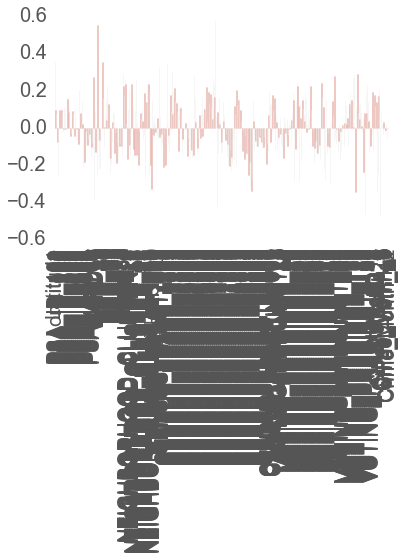

In [24]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=dc.columns)
weights.plot(kind='bar')
plt.show()

**For more improvement and guarding against overfitting:** At this point it would make sense to remove variables that are highly related to one another or ones that are irrelevant and keep going with the weights analysis. What variables would you remove?

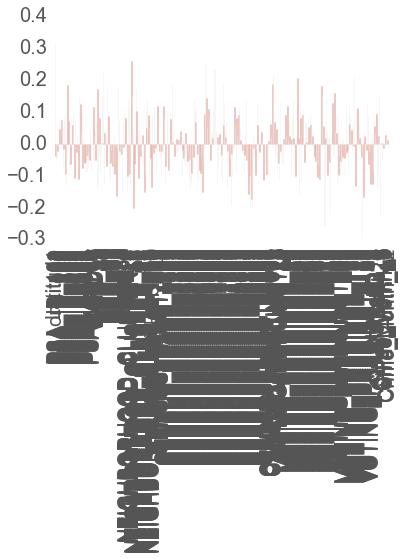

In [25]:
# you can also apply the StandardScaler function insied of the validation loop 
#  but this requires the use of PipeLines in scikit. Here is an example, but we will go over more 
#  thorough examples later in class

from sklearn.pipeline import Pipeline

std_scl = StandardScaler()
#lr_clf = LogisticRegression(penalty='l2', C=0.05) 

multi_class = 'multinomial' 
solver = 'lbfgs'
lr_clf = LogisticRegression(penalty='l2',  
                            multi_class=multi_class,
                            max_iter=200,
                            solver=solver) # get object

# create the pipline
piped_object = Pipeline([('scale', std_scl), ('logit_model', lr_clf)])

# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    
# it is a little odd getting trained objects from a  pipeline:
trained_model_from_pipeline = piped_object.named_steps['logit_model']

# now look at the weights
weights = pd.Series(trained_model_from_pipeline.coef_[0],index=dc.columns)
weights.plot(kind='bar')
plt.show()

# Another Style of Solving This Problem


# Important Modules

#  Graphlab Create Turi


In [26]:
'''
To run this code, YOU MUST MAKE SURE YOU ARE IN THE CORRECT Anaconda Environment!!
RUN THIS COMMAND IN AN ANACONDA COMMAND WINDOW BEFORE EXECUTING THE CODE:
==> activate gl-env
'''

import graphlab as gl
import graphlab

# keep data visualizations within notebook
graphlab.canvas.set_target('ipynb')

In [29]:
# Here we will work with a new dataset df_dc which is similar the dataset dc

# Print current working directory
import os
print "Current working dir : %s" % os.getcwd()

# File exist?
if os.path.isfile('data\DC_Crime_2015_Lab1.csv'):
    print ("File exists")
else:
    print("File DOES NOT Exist")
        
# Read in the crime data from the Lab 1 CSV file
df_dc = pd.read_csv('data\DC_Crime_2015_Lab1.csv')

### *** TO DO:
###  * Incorporate a feature for the weather conditions during START_DATE and END_DATE so we can use rainfall/max temp/min temp in the regression
df_dc['REPORT_DAT'] = pd.to_datetime(df_dc['REPORT_DAT'])
df_dc=df_dc.rename(columns = {'REPORT_DAT':'REPORT_DATE'})
df_dc['START_DATE'] = pd.to_datetime(df_dc['START_DATE'])
df_dc['END_DATE'] = pd.to_datetime(df_dc['END_DATE'])
df_dc['XBLOCK'] = df_dc['XBLOCK'].astype(np.float64)
df_dc['YBLOCK'] = df_dc['YBLOCK'].astype(np.float64)
df_dc['Crime_Month'] = df_dc["START_DATE"].map(lambda x: x.month)
df_dc.info()

Current working dir : G:\jhu\smu\classes\MSDS-7331-Data-Mining-402\lectures\mini-lab\MSDS7331_MiniLab_DC-master
File exists
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36489 entries, 0 to 36488
Data columns (total 27 columns):
REPORT_DATE             36489 non-null datetime64[ns]
SHIFT                   36489 non-null object
OFFENSE                 36489 non-null object
METHOD                  36489 non-null object
DISTRICT                36442 non-null float64
PSA                     36441 non-null float64
WARD                    36489 non-null int64
ANC                     36489 non-null int64
NEIGHBORHOOD_CLUSTER    36489 non-null int64
CENSUS_TRACT            36489 non-null int64
VOTING_PRECINCT         36489 non-null int64
CCN                     36489 non-null int64
XBLOCK                  36489 non-null float64
YBLOCK                  36489 non-null float64
START_DATE              36489 non-null datetime64[ns]
END_DATE                36489 non-null datetime64[ns]
PSA_ID   

In [30]:
# Here we will use the Graph Lab Create API to create a SFRAME based on the pandas DataFrame created earlier.
# instantiate a SFRAME based on the input DataFrame named "dc"

'''
To run this code, you MUST MAKE SURE YOU ARE IN THE CORRECT Anaconda Environment!!
RUN THIS COMMAND IN AN ANACONDA COMMAND WINDOW:
==> activate gl-env
'''
sf_dc = gl.SFrame(df_dc)

This non-commercial license of GraphLab Create for academic use is assigned to bbrock@smu.edu and will expire on August 17, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\Ben\AppData\Local\Temp\graphlab_server_1475883577.log.0


In [31]:
# Show the sf_dc SFRAME show() method.  
# Show a statistical summary of a data table
# Same counter part in Pandas is df.describe()
# https://turi.com/learn/translator/
sf_dc.show()

In [ ]:
from IPython.display import Image 
Image(filename="images/sf_dc_show_1.jpg")

In [ ]:
from IPython.display import Image 
Image(filename="images/sf_dc_show_2.jpg")

In [ ]:
from IPython.display import Image 
Image(filename="images/sf_dc_show_3.jpg")

In [ ]:
from IPython.display import Image 
Image(filename="images/sf_dc_show_4.jpg")

In [ ]:
from IPython.display import Image 
Image(filename="images/sf_dc_show_5.jpg")

In [ ]:
from IPython.display import Image 
Image(filename="images/sf_dc_show_6.jpg")

In [ ]:
from IPython.display import Image 
Image(filename="images/sf_dc_show_7.jpg")

# Logistic Regression

The Logistic Regression solution was based upon using the Turi Machine Learning Platform. Here our goal was to get experience in using both the scipy/sklearn and the Turi Machine Learning platforms.


In [32]:
# Make a train-test split
# split data .8 and seed = 0
train_data, test_data = sf_dc.random_split(0.8, seed=0) # get training and test data

In [33]:
my_custom_features = sf_dc.column_names

In [34]:
my_custom_features

<bound method SFrame.column_names of Columns:
	REPORT_DATE	datetime
	SHIFT	str
	OFFENSE	str
	METHOD	str
	DISTRICT	float
	PSA	float
	WARD	int
	ANC	int
	NEIGHBORHOOD_CLUSTER	int
	CENSUS_TRACT	int
	VOTING_PRECINCT	int
	CCN	int
	XBLOCK	float
	YBLOCK	float
	START_DATE	datetime
	END_DATE	datetime
	PSA_ID	int
	DistrictID	int
	SHIFT_Code	int
	OFFENSE_Code	int
	METHOD_Code	int
	CRIME_TYPE	int
	AGE	int
	TIME_TO_REPORT	int
	Latitude	float
	Longitude	float
	Crime_Month	int

Rows: 36489

Data:
+---------------------------+----------+--------------+--------+----------+
|        REPORT_DATE        |  SHIFT   |   OFFENSE    | METHOD | DISTRICT |
+---------------------------+----------+--------------+--------+----------+
| 2015-03-04 12:05:00+00:00 |   DAY    | THEFT/OTHER  | OTHERS |   3.0    |
| 2015-01-22 09:00:00+00:00 |   DAY    | THEFT F/AUTO | OTHERS |   4.0    |
| 2015-01-03 21:20:00+00:00 | EVENING  | THEFT/OTHER  | OTHERS |   3.0    |
| 2015-01-05 12:44:00+00:00 |   DAY    | THEFT/OTHER  | OT

# Case 3: Logisitic Regression - 

# Multi-Variate Classification "OFFENSE_Code" without creating dummy variables for the Input Catergorical Variables

* **GraphLab Create Turi**

In [35]:
output_feature = ["OFFENSE_Code"]

#  Set up model using all relevant features
custom_lrm_features = ["PSA_ID",
                       "WARD",
                       "ANC",
                       "NEIGHBORHOOD_CLUSTER",
                       "CENSUS_TRACT",
                       "VOTING_PRECINCT",
                       "SHIFT_Code",
                       "Latitude",
                       "Longitude",
                       "Crime_Month"]

In [36]:
# Make a logistic regression model
# The model is trained with the training data (train_data)
lrm_analyzer_model = graphlab.logistic_classifier.create(train_data, 
                                                         target = 'OFFENSE_Code', 
                                                         features = custom_lrm_features)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Logistic regression:

--------------------------------------------------------

Number of examples          : 27733

Number of classes           : 9

Number of feature columns   : 10

Number of unpacked features : 10

Number of coefficients    : 88

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 1.262333     | 0.388021          | 0.370126            |

| 2         | 3        | 1.422752     | 0.384704          | 0.380701            |

| 3         | 4        | 1.534331     | 0.391303          | 0.375413            |

| 4         | 5        | 1.644409     | 0.390834          | 0.377396            |

| 5         | 6        | 1.746482     | 0.390690          | 0.376735            |

| 6         | 7        | 1.846053     | 0.390726          | 0.376735            |

| 10        | 11       | 2.262849     | 0.390726          | 0.376735            |

+-----------+----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

# Evaluate the simple lrm_analyzer_mode model

In [37]:
# Evaluate the model and save the results into a dictionary
print lrm_analyzer_model.evaluate(test_data)

{'f1_score': 0.09895211978585387, 'auc': 0.6614940562608267, 'recall': 0.12485539985436739, 'precision': 0.30669264201765556, 'log_loss': 1.4775301894612707, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int
	class	int

Rows: 900009

Data:
+-----------+-----+-----+------+------+-------+
| threshold | fpr | tpr |  p   |  n   | class |
+-----------+-----+-----+------+------+-------+
|    0.0    | 1.0 | 1.0 | 2863 | 4380 |   0   |
|   1e-05   | 1.0 | 1.0 | 2863 | 4380 |   0   |
|   2e-05   | 1.0 | 1.0 | 2863 | 4380 |   0   |
|   3e-05   | 1.0 | 1.0 | 2863 | 4380 |   0   |
|   4e-05   | 1.0 | 1.0 | 2863 | 4380 |   0   |
|   5e-05   | 1.0 | 1.0 | 2863 | 4380 |   0   |
|   6e-05   | 1.0 | 1.0 | 2863 | 4380 |   0   |
|   7e-05   | 1.0 | 1.0 | 2863 | 4380 |   0   |
|   8e-05   | 1.0 | 1.0 | 2863 | 4380 |   0   |
|   9e-05   | 1.0 | 1.0 | 2863 | 4380 |   0   |
+-----------+-----+-----+------+------+-------+
[900009 rows x 6 columns]
Note: Only the head of the SFrame is 

In [38]:
lrm_analyzer_model.get('coefficients')   # get the weights

name,index,class,value,stderr
(intercept),None,2,-23.9164586695,69.3564311479
PSA_ID,None,2,0.000480447116485,0.000105711194822
WARD,None,2,0.275835329824,0.0762262083384
ANC,None,2,-0.0258756539842,0.00728930850107
NEIGHBORHOOD_CLUSTER,None,2,0.00187307548649,0.00332357967366
CENSUS_TRACT,None,2,-3.74851529389e-05,6.46733076454e-06
VOTING_PRECINCT,None,2,-0.00138391997929,0.000459272264991
SHIFT_Code,None,2,-0.070249592612,0.0210886301266
Latitude,None,2,0.697940818916,0.677827412428
Longitude,None,2,0.0409298801961,0.805627000203


# Logistic Regression Analysis

We will now discuss some advanced features that are specific to logistic regression. Making Predictions Predictions using a GraphLab Create classifier is easy. The classify() method provides a one-stop shop for all that you need from a classifier.

TO DO:

NEED TO FILL THIS OUT LATER.

In [39]:
# Save predictions (probability estimates) to an SArray
predictions = lrm_analyzer_model.classify(test_data)
print predictions

+-------+----------------+
| class |  probability   |
+-------+----------------+
|   1   | 0.407125554913 |
|   1   | 0.413638116873 |
|   1   | 0.395932198129 |
|   1   | 0.407336262998 |
|   2   | 0.429742474106 |
|   1   | 0.407379844491 |
|   2   | 0.432479054564 |
|   1   | 0.378617836709 |
|   1   | 0.392965866729 |
|   1   | 0.441318231759 |
+-------+----------------+
[7243 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


# GraphLab Create's logistic regression model can return predictions for any of these types:

In [40]:
class_predictions = lrm_analyzer_model.predict(test_data, output_type = "class")  # Class

# Evaluating Results

We can also evaluate our predictions by comparing them to known ratings. The results are evaluated using two metrics:

* Classification Accuracy: Fraction of test set examples with correct class label predictions.
* Confusion Matrix: Cross- tabulation of predicted and actual class labels.



In [41]:
result = lrm_analyzer_model.evaluate(test_data)
print "Accuracy         : %s" % result['accuracy']
print "Confusion Matrix : \n%s" % result['confusion_matrix']

Accuracy         : 0.399834322794
Confusion Matrix : 
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      1       |        5        |   55  |
|      6       |        5        |   30  |
|      8       |        5        |   4   |
|      3       |        5        |   28  |
|      7       |        1        |   13  |
|      8       |        1        |   41  |
|      9       |        1        |   2   |
|      2       |        2        |  204  |
|      3       |        1        |  414  |
|      7       |        5        |   12  |
+--------------+-----------------+-------+
[32 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


# Case 4: Logisitic Regression -


# Multi-Variate Classification "OFFENSE_Code"  creation of  dummy variables for the input Categorical variables

* **GraphLab Create Turi**


In [91]:
final_dc_with_dummy_variables = dc

In [100]:
list(final_dc_with_dummy_variables)

['OFFENSE_Code',
 'Latitude',
 'Longitude',
 'PSA_ID_101',
 'PSA_ID_102',
 'PSA_ID_103',
 'PSA_ID_104',
 'PSA_ID_105',
 'PSA_ID_106',
 'PSA_ID_107',
 'PSA_ID_108',
 'PSA_ID_201',
 'PSA_ID_202',
 'PSA_ID_203',
 'PSA_ID_204',
 'PSA_ID_205',
 'PSA_ID_206',
 'PSA_ID_207',
 'PSA_ID_208',
 'PSA_ID_301',
 'PSA_ID_302',
 'PSA_ID_303',
 'PSA_ID_304',
 'PSA_ID_305',
 'PSA_ID_306',
 'PSA_ID_307',
 'PSA_ID_308',
 'PSA_ID_401',
 'PSA_ID_402',
 'PSA_ID_403',
 'PSA_ID_404',
 'PSA_ID_405',
 'PSA_ID_406',
 'PSA_ID_407',
 'PSA_ID_408',
 'PSA_ID_409',
 'PSA_ID_501',
 'PSA_ID_502',
 'PSA_ID_503',
 'PSA_ID_504',
 'PSA_ID_505',
 'PSA_ID_506',
 'PSA_ID_507',
 'PSA_ID_601',
 'PSA_ID_602',
 'PSA_ID_603',
 'PSA_ID_604',
 'PSA_ID_605',
 'PSA_ID_606',
 'PSA_ID_607',
 'PSA_ID_608',
 'PSA_ID_701',
 'PSA_ID_702',
 'PSA_ID_703',
 'PSA_ID_704',
 'PSA_ID_705',
 'PSA_ID_706',
 'PSA_ID_707',
 'PSA_ID_708',
 'WARD_1',
 'WARD_2',
 'WARD_3',
 'WARD_4',
 'WARD_5',
 'WARD_6',
 'WARD_7',
 'WARD_8',
 'ANC_11',
 'ANC_12',
 'ANC_

In [97]:
# final_dc_with_dummy_variables
# Here we will use the Graph Lab Create API to create a SFRAME based on the pandas DataFrame created earlier.
# instantiate a SFRAME based on the input DataFrame named "dc"

'''
To run this code, you MUST MAKE SURE YOU ARE IN THE CORRECT Anaconda Environment!!
RUN THIS COMMAND IN AN ANACONDA COMMAND WINDOW:
==> activate gl-env
'''
sf_dummy_variables_dc = gl.SFrame(final_dc_with_dummy_variables)

In [70]:
output_feature = ["OFFENSE_Code"]

#  Set up model using all relevant features
custom_lrm_features = list(final_dc_with_dummy_variables)

In [101]:
sf_dummy_variables_dc["OFFENSE_Code"]

dtype: int
Rows: 36489
[1L, 2L, 1L, 1L, 2L, 3L, 4L, 1L, 5L, 2L, 6L, 2L, 5L, 5L, 7L, 5L, 2L, 1L, 5L, 5L, 2L, 2L, 5L, 4L, 5L, 4L, 1L, 1L, 2L, 1L, 5L, 3L, 3L, 3L, 1L, 5L, 1L, 2L, 2L, 4L, 2L, 1L, 1L, 2L, 1L, 2L, 1L, 1L, 4L, 2L, 1L, 1L, 2L, 5L, 5L, 1L, 3L, 1L, 2L, 1L, 1L, 2L, 2L, 6L, 2L, 2L, 1L, 2L, 2L, 1L, 4L, 1L, 2L, 1L, 1L, 1L, 5L, 4L, 5L, 2L, 1L, 2L, 5L, 2L, 2L, 2L, 1L, 3L, 2L, 2L, 1L, 2L, 6L, 2L, 1L, 1L, 2L, 2L, 1L, 2L, ... ]

In [102]:
sf_dummy_variables_dc.column_names()

['OFFENSE_Code',
 'Latitude',
 'Longitude',
 'PSA_ID_101',
 'PSA_ID_102',
 'PSA_ID_103',
 'PSA_ID_104',
 'PSA_ID_105',
 'PSA_ID_106',
 'PSA_ID_107',
 'PSA_ID_108',
 'PSA_ID_201',
 'PSA_ID_202',
 'PSA_ID_203',
 'PSA_ID_204',
 'PSA_ID_205',
 'PSA_ID_206',
 'PSA_ID_207',
 'PSA_ID_208',
 'PSA_ID_301',
 'PSA_ID_302',
 'PSA_ID_303',
 'PSA_ID_304',
 'PSA_ID_305',
 'PSA_ID_306',
 'PSA_ID_307',
 'PSA_ID_308',
 'PSA_ID_401',
 'PSA_ID_402',
 'PSA_ID_403',
 'PSA_ID_404',
 'PSA_ID_405',
 'PSA_ID_406',
 'PSA_ID_407',
 'PSA_ID_408',
 'PSA_ID_409',
 'PSA_ID_501',
 'PSA_ID_502',
 'PSA_ID_503',
 'PSA_ID_504',
 'PSA_ID_505',
 'PSA_ID_506',
 'PSA_ID_507',
 'PSA_ID_601',
 'PSA_ID_602',
 'PSA_ID_603',
 'PSA_ID_604',
 'PSA_ID_605',
 'PSA_ID_606',
 'PSA_ID_607',
 'PSA_ID_608',
 'PSA_ID_701',
 'PSA_ID_702',
 'PSA_ID_703',
 'PSA_ID_704',
 'PSA_ID_705',
 'PSA_ID_706',
 'PSA_ID_707',
 'PSA_ID_708',
 'WARD_1',
 'WARD_2',
 'WARD_3',
 'WARD_4',
 'WARD_5',
 'WARD_6',
 'WARD_7',
 'WARD_8',
 'ANC_11',
 'ANC_12',
 'ANC_

In [99]:
custom_lrm_features

['Latitude',
 'Longitude',
 'PSA_ID_101',
 'PSA_ID_102',
 'PSA_ID_103',
 'PSA_ID_104',
 'PSA_ID_105',
 'PSA_ID_106',
 'PSA_ID_107',
 'PSA_ID_108',
 'PSA_ID_201',
 'PSA_ID_202',
 'PSA_ID_203',
 'PSA_ID_204',
 'PSA_ID_205',
 'PSA_ID_206',
 'PSA_ID_207',
 'PSA_ID_208',
 'PSA_ID_301',
 'PSA_ID_302',
 'PSA_ID_303',
 'PSA_ID_304',
 'PSA_ID_305',
 'PSA_ID_306',
 'PSA_ID_307',
 'PSA_ID_308',
 'PSA_ID_401',
 'PSA_ID_402',
 'PSA_ID_403',
 'PSA_ID_404',
 'PSA_ID_405',
 'PSA_ID_406',
 'PSA_ID_407',
 'PSA_ID_408',
 'PSA_ID_409',
 'PSA_ID_501',
 'PSA_ID_502',
 'PSA_ID_503',
 'PSA_ID_504',
 'PSA_ID_505',
 'PSA_ID_506',
 'PSA_ID_507',
 'PSA_ID_601',
 'PSA_ID_602',
 'PSA_ID_603',
 'PSA_ID_604',
 'PSA_ID_605',
 'PSA_ID_606',
 'PSA_ID_607',
 'PSA_ID_608',
 'PSA_ID_701',
 'PSA_ID_702',
 'PSA_ID_703',
 'PSA_ID_704',
 'PSA_ID_705',
 'PSA_ID_706',
 'PSA_ID_707',
 'PSA_ID_708',
 'WARD_1',
 'WARD_2',
 'WARD_3',
 'WARD_4',
 'WARD_5',
 'WARD_6',
 'WARD_7',
 'WARD_8',
 'ANC_11',
 'ANC_12',
 'ANC_13',
 'ANC_14',
 

# Logistic Regression

The Logistic Regression solution was based upon using the Turi Machine Learning Platform. Here our goal was to get experience in using both the scipy/sklearn and the Turi Machine Learning platforms.


In [109]:
# Make a train-test split
# split data .8 and seed = 0
train_data, test_data = sf_dummy_variables_dc.random_split(0.8, seed=0) # get training and te

In [110]:
# Make a logistic regression model
# The model is trained with the training data (train_data)
'''
lrm_model = graphlab.logistic_classifier.create(train_data, 
                                                target = 'OFFENSE_Code', 
                                                features = ['DistrictID_1',
                                                            'DistrictID_2',
                                                            'DistrictID_3',
                                                            'DistrictID_4',
                                                            'DistrictID_5',
                                                            'DistrictID_6',
                                                            'DistrictID_7',
                                                            'SHIFT_Code_1',
                                                            'SHIFT_Code_2',
                                                            'SHIFT_Code_3'])
'''

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Logistic regression:

--------------------------------------------------------

Number of examples          : 27768

Number of classes           : 9

Number of feature columns   : 10

Number of unpacked features : 10

Number of coefficients    : 88

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.172122     | 0.405863          | 0.412043            |

| 2         | 3        | 0.320228     | 0.362576          | 0.366035            |

| 3         | 4        | 0.425304     | 0.407591          | 0.419486            |

| 4         | 5        | 0.522371     | 0.407339          | 0.418133            |

| 5         | 6        | 0.614437     | 0.407339          | 0.418133            |

| 6         | 7        | 0.708504     | 0.407339          | 0.418133            |

+-----------+----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [112]:
# Make a logistic regression model
# The model is trained with the training data (train_data)
lrm_model = graphlab.logistic_classifier.create(train_data, 
                                                target = 'OFFENSE_Code', 
                                                features = custom_lrm_features)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Logistic regression:

--------------------------------------------------------

Number of examples          : 27820

Number of classes           : 9

Number of feature columns   : 492

Number of unpacked features : 492

Number of coefficients    : 3944

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 4        | 0.000018  | 0.950663     | 0.301078          | 0.311360            |

| 2         | 7        | 5.000000  | 1.819280     | 0.386556          | 0.367461            |

| 3         | 8        | 5.000000  | 2.236577     | 0.378828          | 0.369565            |

| 4         | 10       | 1.000000  | 2.916061     | 0.387958          | 0.387097            |

| 5         | 11       | 1.000000  | 3.323351     | 0.261970          | 0.260870            |

| 6         | 15       | 3.000000  | 4.440145     | 0.356254          | 0.326788            |

| 10        | 21       | 1.000000  | 6.518624     | 0.323544          | 0.297335            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

# Evaluate the simple lrm_analyzer_dv_model model

In [113]:
# Evaluate the model and save the results into a dictionary
print lrm_model.evaluate(test_data)

{'f1_score': 0.13571951168626617, 'auc': 0.5378926049499205, 'recall': 0.15463756951351257, 'precision': 0.1929534410928011, 'log_loss': 5.531097849324913, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int
	class	int

Rows: 900009

Data:
+-----------+----------------+----------------+------+------+-------+
| threshold |      fpr       |      tpr       |  p   |  n   | class |
+-----------+----------------+----------------+------+------+-------+
|    0.0    |      1.0       |      1.0       | 2863 | 4380 |   0   |
|   1e-05   | 0.996347031963 | 0.999650716032 | 2863 | 4380 |   0   |
|   2e-05   | 0.995662100457 | 0.998952148096 | 2863 | 4380 |   0   |
|   3e-05   | 0.994292237443 | 0.998952148096 | 2863 | 4380 |   0   |
|   4e-05   | 0.992922374429 | 0.998253580161 | 2863 | 4380 |   0   |
|   5e-05   | 0.992694063927 | 0.997904296193 | 2863 | 4380 |   0   |
|   6e-05   | 0.992237442922 | 0.997904296193 | 2863 | 4380 |   0   |
|   7e-05   | 0.99200913242  | 0.9975

# Get the Weights for the Model

In [114]:
lrm_model.get('coefficients')   # get the weights

name,index,class,value,stderr
(intercept),None,2,-0.911282249951,None
Latitude,None,2,-0.0234198952974,None
Longitude,None,2,0.0118360941047,None
PSA_ID_101,None,2,-0.428790422233,None
PSA_ID_102,None,2,-0.366135726022,None
PSA_ID_103,None,2,-3.34920421091,None
PSA_ID_104,None,2,-0.59506179777,None
PSA_ID_105,None,2,-1.73604019003,None
PSA_ID_106,None,2,-2.45259096865,None
PSA_ID_107,None,2,-0.293488583534,None


# Logistic Regression Analysis

We will now discuss some advanced features that are specific to logistic regression. Making Predictions Predictions using a GraphLab Create classifier is easy. The classify() method provides a one-stop shop for all that you need from a classifier.

TO DO:

NEED TO FILL THIS OUT LATER.

In [115]:
# Save predictions (probability estimates) to an SArray
predictions = lrm_model.classify(test_data)
print predictions

+-------+----------------+
| class |  probability   |
+-------+----------------+
|   5   | 0.481128462936 |
|   5   | 0.843847551948 |
|   5   | 0.79924028504  |
|   5   | 0.770757347909 |
|   1   | 0.447794146033 |
|   5   | 0.770754296982 |
|   1   | 0.898048895939 |
|   1   | 0.722903509225 |
|   3   | 0.650163372221 |
|   3   | 0.677320201432 |
+-------+----------------+
[7243 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


# GraphLab Create's logistic regression model can return predictions for any of these types:

In [116]:
class_predictions = lrm_model.predict(test_data, output_type = "class")  # Class

# Evaluating Results

We can also evaluate our predictions by comparing them to known ratings. The results are evaluated using two metrics:

* Classification Accuracy: Fraction of test set examples with correct class label predictions.
* Confusion Matrix: Cross- tabulation of predicted and actual class labels.

In [117]:
result = lrm_model.evaluate(test_data)
print "Accuracy         : %s" % result['accuracy']
print "Confusion Matrix : \n%s" % result['confusion_matrix']

Accuracy         : 0.325693773298
Confusion Matrix : 
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      7       |        5        |   15  |
|      5       |        4        |   83  |
|      4       |        2        |   43  |
|      3       |        8        |   2   |
|      5       |        5        |  255  |
|      9       |        5        |   2   |
|      1       |        4        |  177  |
|      2       |        4        |   77  |
|      5       |        6        |   7   |
|      8       |        5        |   18  |
+--------------+-----------------+-------+
[58 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


### 2.4 - Support Vector Machine Model for Offense_Code (Exceptional Work)

### 2.5 - Advantages of Each Model (Rubric Item 2)

### 2.6 - Logistic Regression Weights (Rubric Item 3)

### 2.7 - Support Vectors (Rubric Item 4)